# **Fine-Tune W2V2-Bert for low-resource ASR with 🤗 Transformers**

***New (01/2024)***: *This blog post is strongly inspired by "[Fine-tuning XLS-R on Multi-Lingual ASR](https://huggingface.co/blog/fine-tune-xlsr-wav2vec2)"* and ["Fine-tuning MMS Adapter Models for Multi-Lingual ASR"](https://huggingface.co/blog/mms_adapters).

## Motivation

[Whisper](https://huggingface.co/blog/fine-tune-whisper#introduction) is a suite of ASR models, commonly accepted as the best performing models for the ASR task. It provides state-of-the-art performance for English ASR, while being well suited to multilingual fine-tuning from limited resources.

However, when it comes to "resource-poor" languages such as Mongolian, Whisper performs poorly, as seen in section D.2.2 of the [Whisper paper](https://cdn.openai.com/papers/whisper.pdf) - Mongolian or Malayalam achieved over 100% WER at every Whisper checkpoint. The checkpoint available also have a limited vocabulary and therefore cannot be fine-tuned on a language whose alphabet does not overlap with this vocabulary.

In addition, Whisper is a sequence-to-sequence model that performs ASR autoregressively, making it inherently "slow".

Faced with limited resources - both in terms of training data availability and inference constraints - more "frugal" models are needed. In this case, Wav2Vec2-BERT is just the thing.

**Wav2Vec2-BERT** predicts ASR in a single pass, making it much faster than Whisper. As this notebook will show, it requires **little data** to achieve **competitive performance**, is **easily adaptable** to any alphabet, and is **more resource-efficient**.

In fact, it achieves **similar WER performance** on Mongolian ASR compared with [Whisper-large-v3](https://huggingface.co/openai/whisper-large-v3) after similar fine-tuning, while being over **8x faster** and **2.5x more resource-efficient**.


## Notebook Setup

First, let's try to get a good GPU in our colab! With Google Colab's free version it's sadly becoming much harder to get access to a good GPU. With Google Colab Pro, however, one should easily get either a V100 or P100 GPU.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar  3 13:24:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:15:00.0 Off |                    0 |
| N/A   29C    P0              41W / 300W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Before we start, let's install `datasets` and `transformers`. Also, we need `accelerate` for training, `torchaudio` to load audio files and `jiwer` to evaluate our fine-tuned model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric ${}^1$.

In [ ]:
%%capture
!pip install datasets
!pip install transformers
!pip install torchaudio
!pip install jiwer
!pip install accelerate -U

We strongly suggest to upload your training checkpoints directly to the [🤗 Hub](https://huggingface.co/) while training. The [🤗 Hub](https://huggingface.co/) provides:

- Integrated version control: you can be sure that no model checkpoint is lost during training.
- Tensorboard logs: track important metrics over the course of training.
- Model cards: document what a model does and its intended use cases.
- Community: an easy way to share and collaborate with the community!

To do so, you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!). This is done by entering your Hub authentication token when prompted below. Find your Hub authentication token [here](https://huggingface.co/settings/tokens):

In [2]:
from huggingface_hub import notebook_login

notebook_login()


Then you need to install Git-LFS to upload your model checkpoints:

In [3]:
%%capture
!apt install git-lfs




---

${}^1$ In the [paper](https://arxiv.org/pdf/2006.13979.pdf), the model was evaluated using the phoneme error rate (PER), but by far the most common metric in ASR is the word error rate (WER). To keep this notebook as general as possible we decided to evaluate the model using WER.

## Prepare Data, Tokenizer, Feature Extractor

ASR models transcribe speech to text, which means that we both need a feature extractor that processes the speech signal to the model's input format, *e.g.* a feature vector, and a tokenizer that processes the model's output format to text.

In 🤗 Transformers, the Wav2Vec2-BERT model is thus accompanied by both a tokenizer, called [Wav2Vec2CTCTokenizer](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2ctctokenizer), and a feature extractor, called [SeamlessM4TFeatureExtractor](https://huggingface.co/docs/transformers/v4.36.1/en/model_doc/seamless_m4t#transformers.SeamlessM4TFeatureExtractor) that the model shares with the [first](https://huggingface.co/docs/transformers/main/en/model_doc/seamless_m4t) and [second](https://huggingface.co/docs/transformers/main/en/model_doc/seamless_m4_v2t) versions of Seamless-M4T, as they all process audio in the same way.

Let's start by creating the tokenizer to decode the predicted output classes to the output transcription.

### Create `Wav2Vec2CTCTokenizer`

Remember that Wav2Vec2-like models fine-tuned on CTC transcribe an audio file with a single forward pass by first processing the audio input into a sequence of processed context representations and then using the final vocabulary output layer to classify each context representation to a character that represents the transcription.

The output size of this layer corresponds to the number of tokens in the vocabulary, and therefore only on the labeled dataset used for fine-tuning. So in the first step, we will take a look at the chosen dataset of Common Voice and define a vocabulary based on the transcriptions.

For this notebook, we will use [Common Voice's 16.0 dataset](https://huggingface.co/datasets/mozilla-foundation/common_voice_16_0) for Mongolian. Mongolian corresponds to the language code `"mn"`.

Now we can use 🤗 Datasets' simple API to download the data. The dataset name is `"mozilla-foundation/common_voice_16_0"`, the configuration name corresponds to the language code, which is `"mn"` in our case.

**Note**: Before being able to download the dataset, you have to access it by logging into your Hugging Face account, going on the [dataset repo page](https://huggingface.co/datasets/mozilla-foundation/common_voice_16_0) and clicking on:

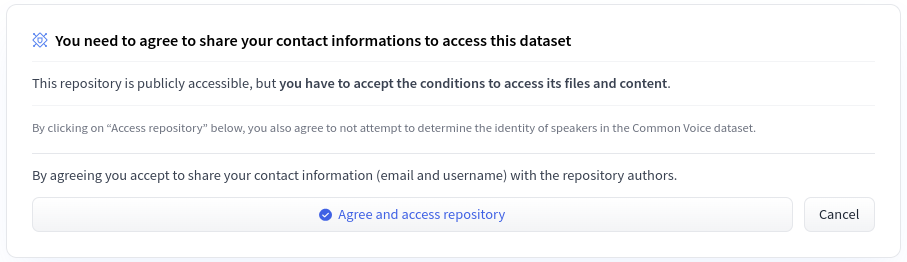

Common Voice has many different splits including `invalidated`, which refers to data that was not rated as "clean enough" to be considered useful. In this notebook, we will only make use of the splits `"train"`, `"validation"` and `"test"`.

Because the Mongolian dataset is so small, we will merge both the validation and training data into a training dataset and only use the test data for validation.

In [ ]:
from datasets import load_dataset, load_metric, Audio

common_voice_train = load_dataset("mozilla-foundation/common_voice_7_0", "rw", split="train+validation", trust_remote_code=True)
common_voice_test = load_dataset("mozilla-foundation/common_voice_7_0", "rw", split="test", trust_remote_code=True)

Many ASR datasets only provide the target text, `'sentence'` for each audio array `'audio'` and file `'path'`. Common Voice actually provides much more information about each audio file, such as the `'accent'`, etc. Keeping the notebook as general as possible, we only consider the transcribed text for fine-tuning.

In [ ]:
common_voice_train = common_voice_train.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
common_voice_test = common_voice_test.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])

Let's write a short function to display some random samples of the dataset and run it a couple of times to get a feeling for the transcriptions.

In [6]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [7]:
show_random_elements(common_voice_train.remove_columns(["path", "audio"]), num_examples=10)

,sentence
0,Abantu beetaaga kaabuyonjo ennungi.
1,Abantu balina okwagalana.
2,Abafumbo ensangi zino baawukana nnyo oba lwaki?
3,"""Ensimbi z'ebyemizannyo zitera okukwatibwa obubi ekireeta okukosa eby'emizannyo"""
4,"""Poliisi erina okukwasaganya emisango gy'emmundu egigenda gyeyongera."""
5,Batuuziza olukiiko mu kisenge kya town hall eggulo.
6,"""Obusanduuko obubeeramu ebikebera omusujja gw'ensiri buyamba abantu ababeera mu byalo ddaala awatali musawo."""
7,Ennaku zino tweyunira nnyo omutimbagano.
8,Abantu abamu beewola kubanga obulamu bwabwe babutambuliza wagulu ku nnyingiza zaabwe.
9,"""Omumwa n'ennyindo bifo bya bulabe nnyo."""


Alright! The transcriptions look fairly clean. Having translated the transcribed sentences, it seems that the language corresponds more to written-out text than noisy dialogue. This makes sense considering that [Common Voice](https://huggingface.co/datasets/mozilla-foundation/common_voice_16_0) is a crowd-sourced read speech corpus.

We can see that the transcriptions contain some special characters, such as `,.?!;:`. Without a language model, it is much harder to classify speech chunks to such special characters because they don't really correspond to a characteristic sound unit. *E.g.*, the letter `"s"` has a more or less clear sound, whereas the special character `"."` does not.
Also in order to understand the meaning of a speech signal, it is usually not necessary to include special characters in the transcription.

Let's simply remove all characters that don't contribute to the meaning of a word and cannot really be represented by an acoustic sound and normalize the text.

In [8]:
import re
chars_to_remove_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\'\»\«]'

def remove_special_characters(batch):
    # remove special characters
    batch["sentence"] = re.sub(chars_to_remove_regex, '', batch["sentence"]).lower()

    return batch

In [9]:
common_voice_train = common_voice_train.map(remove_special_characters)
common_voice_test = common_voice_test.map(remove_special_characters)

Let's look at the processed text labels again.

In [10]:
show_random_elements(common_voice_train.remove_columns(["path","audio"]))

,sentence
0,amayuuni galimibwa mu bitundu ebirimu amazzi
1,ekirombe kibaddemu abantu bangi nnyo
2,okusinziira ku bunene bweddwaliro agamu gayina ebifo ebigendamu ebitanda ebitono
3,tulina okusonda ku sande ejja
4,kirabisse okukosa ebyobufuzi bya disitulikiti
5,abantu basanyufu olweddwaliro eppya
6,abakyala abatendekeddwa oluvannyuma batendeka abalala abaganyulwa mu bukugu
7,emmumbwa emu okuba ngejjanjaba endwadde nga kkumi kye kyannemesa okukkiririza mu kinnansi
8,gye twagenda okwanjula mukyala wa mukwano gwange waaliyo ensiri ennene
9,bwe twongera okwekalakaasa abantu bangi bagenda kukwatibwa basibibwe


In CTC, it is common to classify speech chunks into letters, so we will do the same here.
Let's extract all distinct letters of the training and test data and build our vocabulary from this set of letters.

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars.
It is important to pass the argument `batched=True` to the `map(...)` function so that the mapping function has access to all transcriptions at once.

In [11]:
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [12]:
vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)
vocab_test = common_voice_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_test.column_names)

Map:   0%|          | 0/10175 [00:00<?, ? examples/s]

Map:   0%|          | 0/4276 [00:00<?, ? examples/s]

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [13]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))

In [53]:
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
vocab_dict

{' ': 0,
 '(': 1,
 ')': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'r': 19,
 's': 20,
 't': 21,
 'u': 22,
 'v': 23,
 'w': 24,
 'x': 25,
 'y': 26,
 'z': 27,
 '’': 28}

Cool, we see that all letters of the alphabet occur in the dataset (which is not really surprising) and we also extracted the special character `" "`. Note that we did not exclude this special character because:

The model has to learn to predict when a word is finished or else the model prediction would always be a sequence of chars which would make it impossible to separate words from each other.

One should always keep in mind that pre-processing is a very important step before training your model. E.g., we don't want our model to differentiate between `a` and `A` just because we forgot to normalize the data. The difference between `a` and `A` does not depend on the "sound" of the letter at all, but more on grammatical rules - *e.g.* use a capitalized letter at the beginning of the sentence. So it is sensible to remove the difference between capitalized and non-capitalized letters so that the model has an easier time learning to transcribe speech.




To make it clearer that `" "` has its own token class, we give it a more visible character `|`. In addition, we also add an "unknown" token so that the model can later deal with characters not encountered in Common Voice's training set.

In [54]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

31

In [55]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]
del vocab_dict["("]
del vocab_dict[")"]

Finally, we also add a padding token that corresponds to CTC's "*blank token*".


The "blank token" is a core component of the CTC algorithm. For more information, please take a look at the "Alignment" section [here](https://distill.pub/2017/ctc/).

In [56]:
vocab_dict

{'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'r': 19,
 's': 20,
 't': 21,
 'u': 22,
 'v': 23,
 'w': 24,
 'x': 25,
 'y': 26,
 'z': 27,
 '’': 28,
 '[UNK]': 29,
 '[PAD]': 30,
 '|': 0}

Cool, now our vocabulary is complete and consists of 37 tokens, which means that the linear layer that we will add on top of the pretrained W2V-BERT checkpoint will have an output dimension of 37.

Let's now save the vocabulary as a json file.

In [57]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to load the vocabulary into an instance of the `Wav2Vec2CTCTokenizer` class.

In [58]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

If one wants to re-use the just created tokenizer with the fine-tuned model of this notebook, it is strongly advised to upload the `tokenizer` to the [🤗 Hub](https://huggingface.co/). Let's call the repo to which we will upload the files
`"w2v-bert-2.0-mongolian-colab-CV16.0"`:

In [59]:
repo_name = "w2v-bert-2.0-Kinyarwanda-CV-train-validation-7.0"

and upload the tokenizer to the [🤗 Hub](https://huggingface.co/).

In [60]:
tokenizer.push_to_hub(repo_name)

README.md:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dmusingu/w2v-bert-2.0-luganda-CV-train-validation-7.0/commit/7683a91c7c32c059e1979c5298ee2e4a6a57bebd', commit_message='Upload tokenizer', commit_description='', oid='7683a91c7c32c059e1979c5298ee2e4a6a57bebd', pr_url=None, pr_revision=None, pr_num=None)

Great, you can see the just created repository under `https://huggingface.co/<your-username>/w2v-bert-2.0-mongolian-colab-CV16.0`

### Create `SeamlessM4TFeatureExtractor`

The role of the `SeamlessM4TFeatureExtractor` is to prepare the raw audio input in a format that the model can "understand". It therefore maps the sequence of one-dimensional amplitude values (aka the raw audio input) to a two-dimensional matrix of log-mel spectrogram values. The latter encodes the signal frequency information as a function of time. See [this section](https://huggingface.co/learn/audio-course/chapter1/audio_data#the-frequency-spectrum) from the Audio Transformers course to learn more about spectrograms and why they are important.

Unlike the tokenizer, the feature extractor doesn't need to be "learned" from the data, so we can load it directly from the [initial model checkpoint](https://huggingface.co/facebook/w2v-bert-2.0).


In [61]:
from transformers import SeamlessM4TFeatureExtractor

feature_extractor = SeamlessM4TFeatureExtractor(feature_size=80, num_mel_bins=80, sampling_rate=16000, padding_value=0.0)

Great, W2V-BERT's feature extraction pipeline is thereby fully defined!

For improved user-friendliness, the feature extractor and tokenizer are *wrapped* into a single `Wav2Vec2BertProcessor` class so that one only needs a `model` and `processor` object.

In [62]:
from transformers import Wav2Vec2BertProcessor

processor = Wav2Vec2BertProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)
processor.push_to_hub(repo_name)

README.md:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dmusingu/w2v-bert-2.0-luganda-CV-train-validation-7.0/commit/79e978cca2dbcce626cffc273973bd42bf0899eb', commit_message='Upload processor', commit_description='', oid='79e978cca2dbcce626cffc273973bd42bf0899eb', pr_url=None, pr_revision=None, pr_num=None)

Next, we can prepare the dataset.

### Preprocess Data

So far, we have not looked at the actual values of the speech signal but just the transcription. In addition to `sentence`, our datasets include two more column names `path` and `audio`. `path` states the absolute path of the audio file. Let's take a look.


In [23]:
common_voice_train[0]["path"]

'/ocean/projects/cis230036p/musinguz/datasets/downloads/extracted/11b22b6c2342f913cd6b27d3263eb9cdf01ca3c9f4638cc5e604e753632eb67b/cv-corpus-7.0-2021-07-21/lg/clips/common_voice_lg_23717967.mp3'

W2V-BERT expects the input in the format of a 1-dimensional array of 16 kHz. This means that the audio file has to be loaded and resampled.

 Thankfully, `datasets` does this automatically by calling the other column `audio`. Let try it out.

In [24]:
common_voice_train[0]["audio"]

{'path': '/ocean/projects/cis230036p/musinguz/datasets/downloads/extracted/11b22b6c2342f913cd6b27d3263eb9cdf01ca3c9f4638cc5e604e753632eb67b/cv-corpus-7.0-2021-07-21/lg/clips/common_voice_lg_23717967.mp3',
 'array': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.10868948e-06, 1.66715399e-04, 0.00000000e+00]),
 'sampling_rate': 48000}


Great, we can see that the audio file has automatically been loaded. This is thanks to the new [`"Audio"` feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=audio#datasets.Audio) introduced in `datasets == 4.13.3`, which loads and resamples audio files on-the-fly upon calling.

In the example above we can see that the audio data is loaded with a sampling rate of 48kHz whereas Wav2Vec2-BERT was pre-trained at a sampling rate of 16kHz. The sampling rate plays an important role in that it defines how many data points of the speech signal are measured per second. Therefore, sampling with a higher sampling rate results in a better approximation of the *real* speech signal but also necessitates more values per second.

A pre-trained checkpoint expects its input data to have been sampled more or less from the same distribution as the data it was trained on. The same speech signals sampled at two different rates have a very different distribution, *e.g.*, doubling the sampling rate results in data points being twice as long. Thus,
before fine-tuning a pre-trained checkpoint of an ASR model, it is crucial to verify that the sampling rate of the data that was used to pre-train the model matches the sampling rate of the dataset used to fine-tune the model.

In [25]:
common_voice_train = common_voice_train.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_test = common_voice_test.cast_column("audio", Audio(sampling_rate=16_000))

Let's take a look at `"audio"` again.

In [26]:
common_voice_train[0]["audio"]

{'path': '/ocean/projects/cis230036p/musinguz/datasets/downloads/extracted/11b22b6c2342f913cd6b27d3263eb9cdf01ca3c9f4638cc5e604e753632eb67b/cv-corpus-7.0-2021-07-21/lg/clips/common_voice_lg_23717967.mp3',
 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.39800841e-04,  1.00304111e-04, -2.85751939e-05]),
 'sampling_rate': 16000}

This seemed to have worked! Let's listen to a couple of audio files to better understand the dataset and verify that the audio was correctly loaded.

**Note**: *You can click the following cell a couple of times to listen to different speech samples.*

In [27]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(common_voice_train)-1)

print(common_voice_train[rand_int]["sentence"])
ipd.Audio(data=common_voice_train[rand_int]["audio"]["array"], autoplay=True, rate=16000)

ebikuta bya lumonde embizzi zibirya nga obifumbye


It seems like the data is now correctly loaded and resampled.

It can be heard, that the speakers change along with their speaking rate, accent, and background environment, etc. Overall, the recordings sound acceptably clear though, which is to be expected from a crowd-sourced read speech corpus.

Let's do a final check that the data is correctly prepared, by printing the shape of the speech input, its transcription, and the corresponding sampling rate.

**Note**: *You can click the following cell a couple of times to verify multiple samples.*

In [28]:
rand_int = random.randint(0, len(common_voice_train)-1)

print("Target text:", common_voice_train[rand_int]["sentence"])
print("Input array shape:", common_voice_train[rand_int]["audio"]["array"].shape)
print("Sampling rate:", common_voice_train[rand_int]["audio"]["sampling_rate"])

Target text: ate era ne mu nsi mwe nnyini omuli akawuka ka corona ebitundu ebimu baabiggalawo obutabigendamu
Input array shape: (121536,)
Sampling rate: 16000


Good! Everything looks fine - the data is a 1-dimensional array, the sampling rate always corresponds to 16kHz, and the target text is normalized.

Finally, we can leverage `Wav2Vec2BertProcessor` to process the data to the format expected by `Wav2Vec2BertForCTC` for training. To do so let's make use of Dataset's [`map(...)`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.DatasetDict.map) function.

First, we load and resample the audio data, simply by calling `batch["audio"]`.
Second, we extract the `input_features` from the loaded audio file. In our case, the `Wav2Vec2BertProcessor` creates a more complex representation as the raw waveform, known as [Log-Mel feature extraction](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).
Third, we encode the transcriptions to label ids.


In [29]:
def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_features"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    batch["input_length"] = len(batch["input_features"])

    batch["labels"] = processor(text=batch["sentence"]).input_ids
    return batch

Let's apply the data preparation function to all examples.

In [30]:
common_voice_train = common_voice_train.map(prepare_dataset, remove_columns=common_voice_train.column_names)
common_voice_test = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names)

**Note**: `datasets` automatically takes care of audio loading and resampling. If you wish to implement your own costumized data loading/sampling, feel free to just make use of the `"path"` column instead and disregard the `"audio"` column.

Awesome, now we are ready to start training!

## Training

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, W2V-BERT has a much larger input length than output length. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning W2V-BERT requires a special padding data collator, which we will define below.

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/7e61d56a45c19284cfda0cee8995fb552f6b1f4e/examples/pytorch/speech-recognition/run_speech_recognition_ctc.py#L219).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_features` and `labels` differently and thus applies to separate padding functions on them. This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [31]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2BertProcessor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        labels_batch = self.processor.pad(
            labels=label_features,
            padding=self.padding,
            return_tensors="pt",
        )
        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [32]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. As mentioned earlier, the
predominant metric in ASR is the word error rate (WER), hence we will use it in this notebook as well.

In [33]:
wer_metric = load_metric("wer")

/tmp/ipykernel_55777/24688115.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")
/ocean/projects/cis230036p/musinguz/miniconda3/envs/glam/lib/python3.8/site-packages/datasets/load.py:753: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.0/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


The model will return a sequence of logit vectors:
$\mathbf{y}_1, \ldots, \mathbf{y}_m$ with $\mathbf{y}_1 = f_{\theta}(x_1, \ldots, x_n)[0]$ and $n >> m$.

A logit vector $\mathbf{y}_1$ contains the log-odds for each word in the vocabulary we defined earlier, thus $\text{len}(\mathbf{y}_i) =$ `config.vocab_size`. We are interested in the most likely prediction of the model and thus take the `argmax(...)` of the logits. Also, we transform the encoded labels back to the original string by replacing `-100` with the `pad_token_id` and decoding the ids while making sure that consecutive tokens are **not** grouped to the same token in CTC style ${}^1$.

In [34]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Now, we can load the pretrained checkpoint of [Wav2Vec2-XLS-R-300M](https://huggingface.co/facebook/wav2vec2-xls-r-300m). The tokenizer's `pad_token_id` must be to define the model's `pad_token_id` or in the case of `Wav2Vec2BertForCTC` also CTC's *blank token* ${}^2$. To save GPU memory, we enable PyTorch's [gradient checkpointing](https://pytorch.org/docs/stable/checkpoint.html) and also set the loss reduction to "*mean*".

Since, we're only training a small subset of weights, the model is not prone to overfitting. Therefore, we make sure to disable all dropout layers.

**Note**: When using this notebook to train W2V-BERT on another language of Common Voice those hyper-parameter settings might not work very well. Feel free to adapt those depending on your use case.

In [80]:
from transformers import Wav2Vec2BertForCTC

model = Wav2Vec2BertForCTC.from_pretrained(
    "facebook/w2v-bert-2.0",
    attention_dropout=0.0,
    hidden_dropout=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.0,
    layerdrop=0.0,
    ctc_loss_reduction="mean",
    add_adapter=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)+2,
)

Some weights of Wav2Vec2BertForCTC were not initialized from the model checkpoint at facebook/w2v-bert-2.0 and are newly initialized: ['adapter.layers.0.ffn.intermediate_dense.bias', 'adapter.layers.0.ffn.intermediate_dense.weight', 'adapter.layers.0.ffn.output_dense.bias', 'adapter.layers.0.ffn.output_dense.weight', 'adapter.layers.0.ffn_layer_norm.bias', 'adapter.layers.0.ffn_layer_norm.weight', 'adapter.layers.0.residual_conv.bias', 'adapter.layers.0.residual_conv.weight', 'adapter.layers.0.residual_layer_norm.bias', 'adapter.layers.0.residual_layer_norm.weight', 'adapter.layers.0.self_attn.linear_k.bias', 'adapter.layers.0.self_attn.linear_k.weight', 'adapter.layers.0.self_attn.linear_out.bias', 'adapter.layers.0.self_attn.linear_out.weight', 'adapter.layers.0.self_attn.linear_q.bias', 'adapter.layers.0.self_attn.linear_q.weight', 'adapter.layers.0.self_attn.linear_v.bias', 'adapter.layers.0.self_attn.linear_v.weight', 'adapter.layers.0.self_attn_conv.bias', 'adapter.layers.0.self_

In a final step, we define all parameters related to training.
To give more explanation on some of the parameters:
- `group_by_length` makes training more efficient by grouping training samples of similar input length into one batch. This can significantly speed up training time by heavily reducing the overall number of useless padding tokens that are passed through the model
- `learning_rate` was heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the Common Voice dataset and might be suboptimal for other speech datasets.

For more explanations on other parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

During training, a checkpoint will be uploaded asynchronously to the hub every 600 training steps. It allows you to also play around with the demo widget even while your model is still training.

**Note**: If one does not want to upload the model checkpoints to the hub, simply set `push_to_hub=False`.

### Wandb

In [36]:
import wandb
wandb.login(key = "5a941fa1f4ffe0bb9b37300fd0f27eed93e2e848")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dmusingu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/musinguz/.netrc


True

In [37]:
%env WANDB_PROJECT=W2V-BERT-LugandaASR
%env WANDB_LOG_MODEL="checkpoint"

env: WANDB_PROJECT=W2V-BERT-LugandaASR
env: WANDB_LOG_MODEL="checkpoint"


In [92]:
!nvidia-smi

Sun Mar  3 11:53:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:15:00.0 Off |                    0 |
| N/A   31C    P0              55W / 300W |  27717MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [93]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="/ocean/projects/cis220031p/musinguz/"+repo_name+"extended",
  group_by_length=True,
  per_device_train_batch_size=32,
  gradient_accumulation_steps=2,
  evaluation_strategy="steps",
  num_train_epochs=10,
  gradient_checkpointing=True,
  fp16=True,
  report_to="wandb",
  save_steps=600,
  eval_steps=300,
  logging_steps=300,
  learning_rate=5e-5,
  warmup_steps=500,
  save_total_limit=2,
  # push_to_hub=True,
  dataloader_pin_memory = True,
  dataloader_num_workers=4,
)

Now, all instances can be passed to Trainer and we are ready to start training!

In [94]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_test,
    tokenizer=processor.feature_extractor,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.




---

${}^1$ To allow models to become independent of the speaker rate, in CTC, consecutive tokens that are identical are simply grouped as a single token. However, the encoded labels should not be grouped when decoding since they don't correspond to the predicted tokens of the model, which is why the `group_tokens=False` parameter has to be passed. If we wouldn't pass this parameter a word like `"hello"` would incorrectly be encoded, and decoded as `"helo"`.

${}^2$ The blank token allows the model to predict a word, such as `"hello"` by forcing it to insert the blank token between the two l's. A CTC-conform prediction of `"hello"` of our model would be `[PAD] [PAD] "h" "e" "e" "l" "l" [PAD] "l" "o" "o" [PAD]`.

### Training

Training will take multiple hours depending on the GPU allocated to this notebook. While the trained model yields somewhat satisfying results on *Common Voice*'s test data of Mongolian, it is by no means an optimally fine-tuned model. The purpose of this notebook is just to demonstrate how to fine-tune W2V-BERT on an ASR dataset.

In case you want to use this google colab to fine-tune your model, you should make sure that your training doesn't stop due to inactivity. A simple hack to prevent this is to paste the following code into the console of this tab (*right mouse click -> inspect -> Console tab and insert code*).

```javascript
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);
```

Depending on what GPU was allocated to your google colab it might be possible that you are seeing an `"out-of-memory"` error here. In this case, it's probably best to reduce `per_device_train_batch_size` to 8 or even less and increase [`gradient_accumulation`](https://huggingface.co/transformers/master/main_classes/trainer.html#trainingarguments).

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Wer
300,0.024700,0.279014,0.226773
600,0.048600,0.239152,0.231061
900,0.032300,0.274396,0.219374


/ocean/projects/cis230036p/musinguz/miniconda3/envs/glam/lib/python3.8/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/ocean/projects/cis230036p/musinguz/miniconda3/envs/glam/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_

### Note
Including the other split in training the model results in a high WER.    
The performance of the model was not as good as when only the train split is used.   

The training loss and validation WER go down nicely. In comparison, the same training with XLR-S, has a final WER of 41.97%.

You can now upload the result of the training to the 🤗 Hub, just execute this instruction:

In [84]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dmusingu/w2v-bert-2.0-luganda-CV-train-validation-7.0/commit/6901507f0a57f5d705573dfffc412df12bb58329', commit_message='End of training', commit_description='', oid='6901507f0a57f5d705573dfffc412df12bb58329', pr_url=None, pr_revision=None, pr_num=None)

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier "your-username/the-name-you-picked" so for instance:

```python
from transformers import AutoModelForCTC, Wav2Vec2BertProcessor

model = AutoModelForCTC.from_pretrained("dmusingu/w2v-bert-2.0-luganda-CV7.0")
processor = Wav2Vec2BertProcessor.from_pretrained("dmusingu/w2v-bert-2.0-luganda-CV7.0")
```

For more examples of how W2V-BERT can be fine-tuned, please take a look at the [official speech recognition examples](https://github.com/huggingface/transformers/tree/master/examples/pytorch/speech-recognition#examples).

### Evaluation

As a final check, let's load the model and verify that it indeed has learned to transcribe Mongolian speech.

Let's first load the pretrained checkpoint.

In [85]:
from transformers import AutoModelForCTC, Wav2Vec2BertProcessor

model = AutoModelForCTC.from_pretrained("dmusingu/" + repo_name).to("cuda")
processor = Wav2Vec2BertProcessor.from_pretrained("dmusingu/" + repo_name)

config.json:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Let's process the audio, run a forward pass and predict the ids

In [86]:
input_dict = common_voice_test[0]

logits = model(torch.tensor(input_dict["input_features"]).to("cuda").unsqueeze(0)).logits

pred_ids = torch.argmax(logits, dim=-1)[0]


Finally, we can decode the example from the predicted tokens:

In [87]:
processor.decode(pred_ids)

'ebintu bizibu okimanyi maama womwana oyo yeetuze lwa bbaawe kuwasa mukyala mulala'

And compare it to the reference transcription:

In [88]:
processor.decode(input_dict["labels"]).lower()

'ebintu bizibu okimanyi mama womwana oyo yetuze lwa bawe kuwasa mukyala mulala'

In [89]:
# Evaluation is carried out with a batch size of 1
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_features"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)

  return batch

results = common_voice_test.map(map_to_result, remove_columns=common_voice_test.column_names)

Map:   0%|          | 0/4276 [00:00<?, ? examples/s]

In [90]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test WER: 0.194


In [91]:
# Chech the errors made by the model
show_random_elements(results)

,pred_str,text
0,abazadde babayizi be baagoba ku ssomero bakkirizza okukozesa emmeeza abaana ze baayonoona,abazadde babayizi be baagoba ku ssomero bakkirizza okukozesa emmeeza abaana ze bayonoona
1,aka akantu kannyumidde nnyo bambi,ako akantu kakunyumidde nnyo bambi
2,abakulembeze abenjawulo beetabye mu musomo,abakulembeze abenjawulo beetabye mu musomo
3,ttiimu ablaine yemu ku ttiimu esisinga mu uganda,ttiimu ya proline yemu ku ttiimu ezisinga mu uganda
4,buzibu ki obuva mu bufumbo bwekito,buzibu ki obuva mu bufumbo bwekito
5,omukulembeze omulungi yoyo ategeera ebizibu byabo baakulembera,omukulembeze omulungi yoyo ategeera ebizibu byabo bakulembera
6,maama wange amanyi okuboobeza emmere,maama wange amanyi okuboobeza emmere
7,ensi ezimu ze tugenda okukoleramu obwayaaya nnungi mu ndabika naye ebikolebwayo bya ttabbu,ensi ezimu ze tugenda okukoleramu obwa yaaya nnungi mu ndabika naye ebikolebwayo bya ttabu
8,entalo zireetera abantu okuvuma ebifo byabwe ne bagenda mu bifo ebirimu eddembe,entalo zireetera abantu okuva mu bifo byabwe ne bagenda mu bifo ebirimu eddembe
9,omutamiivu abeera nga eyeebase naye nga ategeera bulungi nnyo,omutamiivu abeera nga eyeebase naye nga ategeera bulungi nnyo


### Build Language model

Alright! The transcription can definitely be recognized from our prediction, but it is not perfect yet. Training the model a bit longer, spending more time on the data preprocessing, and especially using a language model for decoding would certainly improve the model's overall performance.

For a demonstration model on a low-resource language, the results are quite acceptable however 🤗.


## Scaling-up the training

We've shown in this blogpost how Meta's `w2v-bert-2.0` fine-tuning can give near state-of-the-art performance on low-resource languages.

To take things a step further, I've put together a set of tips and pointers given by my colleagues at Hugging Face on how to scale up training for this model. Many thanks to [Patrick](https://huggingface.co/patrickvonplaten), [Sanchit](https://huggingface.co/sanchit-gandhi) and [Pablo](https://huggingface.co/Molbap) for their valuable expertise and help 🤗

Note that Common Voice newest version ([CV16](https://huggingface.co/datasets/mozilla-foundation/common_voice_16_0)) provides many more hours of data and for may languages and thus provides fertile ground for much more efficient models in many low-resource languages.


### Datasets-related tips

CTC ASR is typically done with lower-case, un-punctuated transcriptions. This simplifies the CTC task since the model is considered as "acoustic only", meaning that it makes prediction largely based on the phonetics sounds of the audio, rather than any language modelling context of the spoken sentence.

Very low-frequency characters can significantly affect loss during learning by causing loss spikes via erroneous targets. By default, the CTC tokenizer created in this blog post would add them to the vocabulary even if their frequency is negligible compared to more frequent characters. We can treat these characters as "errors" in the dataset annotation, so that they can be removed from the vocabulary, and simply classified as `"[UNK]"` during training.

It is therefore absolutely necessary to recheck the tokenizer vocabulary and remove all low-frequency characters, in much the same way as we removed Latin characters when creating the tokenizer.

Note that the Common Voice dataset is particularly prone to such "wrong" characters, for example characters from other languages (阪).

### Training-related tips

**Average duration seen by each CTC token:** According to the advice of my colleagues, the ideal ratio of duration seen per CTC token is 10 to 35 ms. In other words, to be able to learn and predict correctly, the duration of the acoustic information a CTC token needs to see should be neither too low nor too high. In fact, it should more or less correspond to a fraction of the time it takes us humans to pronounce a phoneme.

This is something that came to light when I started refining this new W2V2-Bert model (you can find the logs of one of my experiments [here](https://wandb.ai/ylacombe/huggingface/runs/4y8pd2gq)). I quickly noticed that the loss curve of my model was initially going nicely downwards, as expected, but at some point it started to explode.

After discussing this with my colleagues, I realized that I had been using a [basic checkpoint with no architecture changes](https://huggingface.co/facebook/w2v-bert-2.0), and that each CTC token was seeing a piece of the signal for 30 to 60 ms. Adding an adapter layer was enough to reduce the signal chunk sampling to the desired duration.


**Under-training:** After showing this blog post [training run](https://huggingface.co/hf-audio/w2v-bert-2.0-mongolian-colab-CV16.0#training-results) and another [training attempt](https://wandb.ai/ylacombe/huggingface/runs/nasaux7f?workspace=user-ylacombe) on English Common Voice (about 2.5k validated hours) to my colleagues, they pointed out that the model was severely under-trained, something that could have been spotted by looking at the loss curve, which looks like it was stopped in the middle of a steep descent. This pointed out other issues as well, notably the loss curve not being smooth enough, a sign of wrong hyper-parameters settings.

Here are a few ways to solve under-training in our case:
- the warm-up rate might be too high, causing the learning rate to drop too quickly. A way to solve this would be keep the warmup ratio to 5 to 15% and scale up the number of epochs. The warm-up steps are essential to gradually bring the new language-model head weights into alignment with the pre-trained model.
- Loss curve lack of smoothness can be played around thanks to [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)'s [\\( \beta_2 \\)](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.adam_beta2) which can typically set from 0.95 to 0.98 by default.




*Related posts and additional links are listed here:*
- [**Official paper**](https://huggingface.co/papers/2305.13516)
- [**Original cobebase**](https://ai.meta.com/research/publications/seamless-multilingual-expressive-and-streaming-speech-translation/)
- [**Transformers Docs**](https://huggingface.co/docs/transformers/main/en/model_doc/wav2vec2-bert)
- [**Related XLS-R blog post**](https://huggingface.co/blog/fine-tune-xlsr-wav2vec2)
- [**Related MMS blog post**](https://huggingface.co/blog/mms_adapters)
